<font size=5>Machine Learning Model Diagnostics and Validation</font>

Updated on July 22, 2022

This demo (based on CalifrniaHousing data, a regression task) covers: 

- Accuracy, WeakSpot and Overfit

- Reliability Testing

- Robustness and Resilience Testing

- Model Comparison and Benchmarking

# Install PiML Toolbox

- Run `!pip install piml` to install the latest version of PiML.
- In Google Colab, we need restart the runtime in order to use newly installed version.

In [ ]:
!pip install piml

# Load and Prepare Data

- Initilaize a new experiment by `piml.Experiment()`
- Low-code interactive interface, or
- High-code autorun scripts (optional)  


In [ ]:
from piml import Experiment
exp = Experiment()

## Low-code Interface

In [2]:
# Choose CaliforniaHousing_trim2
exp.data_loader()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [3]:
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [4]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [5]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

## High-code Scripts (optional)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  MedHouseVal  
0        -122.23        4.526  
1        -122.22        3.585  
2        -122.24        3.521  
3        -122.25        3.413  
4        -122.25        3.422  
...          ...          ...  
20635    -121.09        0.781  
20636    -121.21        0.771  
20637    -121.22        0.923  
20638    -121.32        0.847  
20639    -121.24        0.894  

[20640 rows x 9 columns]

HTML(value='Data Shape:(20640, 9)')

0            1
0  Excluded columns           []
1   Target variable  MedHouseVal
2     Sample weight         None
3         Task type   Regression
4      Split method       Random
5        Test ratio          0.2
6      Random state            0

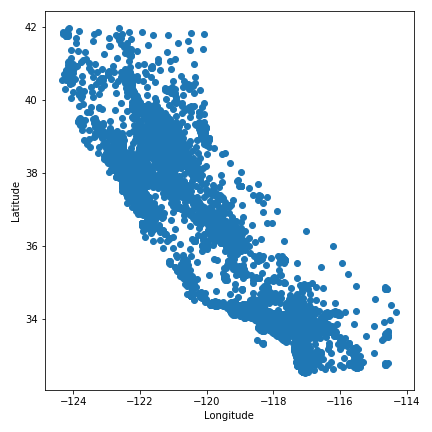

In [7]:
exp.data_loader(data='CaliforniaHousing_trim2')

exp.data_summary(feature_exclude=[])

exp.data_prepare(target='MedHouseVal', task_type='regression', test_ratio=0.2, random_state=0)

exp.eda(show='bivariate', bi_features=['Longitude', 'Latitude'])

# Train Black-Box Models 

e.g. XGBoost (depth 7)

In [8]:
from xgboost import XGBRegressor

exp.model_train(XGBRegressor(n_estimators=200, max_depth=7), name='XGBoost7')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value="<p class='notification info'>Register XGBoost7 Done</p>")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

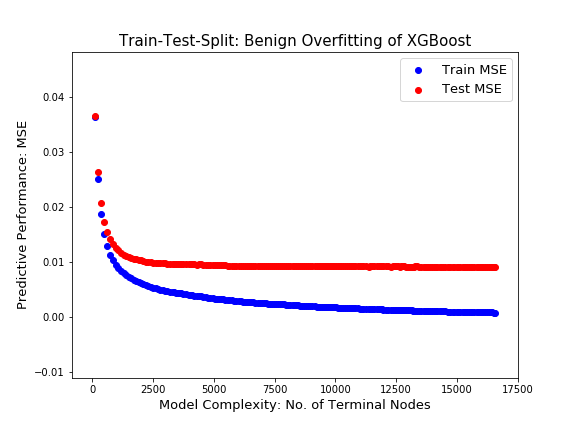

In [11]:
# Benign Overftting under train-test-split framework

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from sklearn.metrics import mean_squared_error

train_x, train_y, train_sample_weight = exp.get_model("XGBoost7").get_data(train=True)
test_x, test_y, test_sample_weight = exp.get_model("XGBoost7").get_data(test=True)


def score(clf, iteration_range):
    train_mse = mean_squared_error(train_y, clf.predict(train_x, iteration_range=iteration_range))
    test_mse = mean_squared_error(test_y, clf.predict(test_x, iteration_range=iteration_range))
    tree_idx = np.logical_and(xgbinfo["Tree"] < iteration_range[1], xgbinfo["Tree"] >= iteration_range[0])
    n_leaves = np.sum(xgbinfo[tree_idx].loc[:, ["Feature"]].values == "Leaf")
    return {'n_leaves': n_leaves, 'train_mse': train_mse, 'test_mse': test_mse}

all_metrics = []
xgbinfo = exp.get_model("XGBoost7").estimator.get_booster().trees_to_dataframe()
n_iter = 200
for i in range(n_iter):
    metrics = score(exp.get_model("XGBoost7").estimator, (0, i + 1))
    all_metrics.append(metrics)
all_resluts = pd.DataFrame(all_metrics)

plt.figure(figsize=(8,6))
plt.scatter(all_resluts["n_leaves"], all_resluts["train_mse"], color="blue", label="Train MSE")
plt.scatter(all_resluts["n_leaves"], all_resluts["test_mse"], color="red", label="Test MSE")
plt.legend(fontsize=13)
# plt.yscale("log")
plt.ylabel("Predictive Performance: MSE", fontsize=13)
plt.xlabel("Model Complexity: No. of Terminal Nodes", fontsize=13)
plt.title("Train-Test-Split: Benign Overfitting of XGBoost", fontsize=15)
plt.show()

In [12]:
# Choose XGBoost7, check Overfit
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Train Interpretable Models


In [13]:
# ----------------------------------
# Low-code Interface
# ----------------------------------

# Choose EBM, GAMI-Net, ReLU-DNN (default) and Sparse-ReLU-DNN (L1=0.0005)
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [14]:
# ----------------------------------
# High-code Scripts (optional)
# ----------------------------------

# EBM: Explainable Boosting Machine from MS Research
from piml.models import ExplainableBoostingRegressor

clf = ExplainableBoostingRegressor(interactions=10, random_state=0)
exp.model_train(model=clf, name='EBM')
exp.model_diagnose(model="EBM", show='accuracy_table')

# GAMI-Net: GAMI Neural Networks by WF CMoR
from piml.models import GAMINetRegressor

clf = GAMINetRegressor(interact_num=10, 
                       subnet_size_main_effect=[20], 
                       subnet_size_interaction=[20, 20])
exp.model_train(model=clf, name='GAMI-Net')
exp.model_diagnose(model="GAMI-Net", show='accuracy_table')

# ReLU-DNN: ReLU Deep Neural Networks (default parameters)
from piml.models import ReluDNNRegressor

clf = ReluDNNRegressor(hidden_layer_sizes=(40, 40), l1_reg=1e-05,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=clf, name='ReLU-DNN')
exp.model_diagnose(model="ReLU-DNN", show='accuracy_table')

# Sparse-ReLU-DNN: set L1-Regularization to be 0.005
clf = ReluDNNRegressor(hidden_layer_sizes=(40, 40), l1_reg=0.0005,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=clf, name='Sparse-ReLU-DNN')
exp.model_diagnose(model="Sparse-ReLU-DNN", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value="<p class='notification info'>Register EBM Done</p>")

MSE     MAE       R2
                              
Train  0.0108  0.0722   0.8100
Test   0.0116  0.0742   0.7907
Gap    0.0008  0.0021  -0.0193

HTML(value="<p class='notification info'>Register GAMI-Net Done</p>")

MSE     MAE       R2
                              
Train  0.0115  0.0735   0.7978
Test   0.0122  0.0759   0.7800
Gap    0.0007  0.0024  -0.0178

HTML(value="<p class='notification info'>Register ReLU-DNN Done</p>")

MSE     MAE       R2
                              
Train  0.0117  0.0735   0.7951
Test   0.0122  0.0757   0.7793
Gap    0.0006  0.0022  -0.0158

HTML(value="<p class='notification info'>Register Sparse-ReLU-DNN Done</p>")

MSE     MAE       R2
                              
Train  0.0155  0.0886   0.7269
Test   0.0157  0.0898   0.7173
Gap    0.0001  0.0012  -0.0097

# Interpret/Explain

In [15]:
# Choose EBM, GAMI-Net, ReLU-DNN or Sparse-ReLU-DNN
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [16]:
# Choose EBM, GAMI-Net, ReLU-DNN or Sparse-ReLU-DNN, as well as arbitrary black-box models upon registration
exp.model_explain()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

# Diagnose/Compare

In [17]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [18]:
# Register Other Models, e.g. Shallow XGBoost

from xgboost import XGBRegressor
exp.model_train(model=XGBRegressor(max_depth=2, n_estimators=500), name='XGBoost2')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value="<p class='notification info'>Register XGBoost2 Done</p>")

In [19]:
# Compare EBM, GAMI-Net and XGBoost2 (Lower-order FANOVA models)
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [20]:
# Compare ReLU-DNN, Sparse-ReLU-DNN, and XGBoost7 (Complex ML models)
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>